In [75]:
import os
import glob
import functools
from sklearn.model_selection import train_test_split
import numpy as np

import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers, losses

tf.enable_eager_execution()
tf.VERSION

'1.13.1'

# Set up

In [76]:
common_root = r'/awlab/users/chsu/WorkSpace/tensorflow/segmentation/data/plate_2017017086_ki67'

img_dir = os.path.join(common_root, 'images')
mask_dir = os.path.join(common_root, 'masks')

max_intensity = 4095.
batch_size = 5
epochs = 5

In [4]:
x_train_fnames = sorted(glob.glob(os.path.join(img_dir,'*-2.png'))) # nucleus images
y_train_fnames = sorted(glob.glob(os.path.join(mask_dir,'*_nucleus.jpeg'))) # nucleus masks     


# Split into training and validation
x_train_fnames, x_val_fnames, y_train_fnames, y_val_fnames = train_test_split(x_train_fnames, y_train_fnames, 
                                                                              test_size=0.2, random_state=43)

num_train_data = len(x_train_fnames)
num_val_data = len(x_val_fnames)

print("Number of training samples: {}".format(num_train_data))
print("Number of validation samples: {}".format(num_val_data))

Number of training samples: 388
Number of validation samples: 98


In [5]:
idx = np.random.choice(num_train_data)
print(os.path.basename(x_train_fnames[idx]))
print(os.path.basename(y_train_fnames[idx]))

CH_171219_Vh31_Goldilocks_plate_2017017086_ki67_F4_0002-2.png
CH_171219_Vh31_Goldilocks_plate_2017017086_ki67_F4_0002_nucleus.jpeg


# Build the input pipeline

### Get images and masks from path names

In [69]:
def _get_image_from_path(img_path, mask_path):
    img = tf.image.decode_png(tf.read_file(img_path), channels=1, dtype=tf.uint16)
    img = tf.image.convert_image_dtype(tf.to_float(img) / max_intensity, tf.uint8)
    mask = tf.image.decode_jpeg(tf.read_file(mask_path), channels=1)
    
    # Remove bounday 100 pixels since masks touching boundaries were removed
    w = 100
    img = img[w:-w,w:-w,:]
    mask = mask[w:-w,w:-w,:]
    
    return img, mask

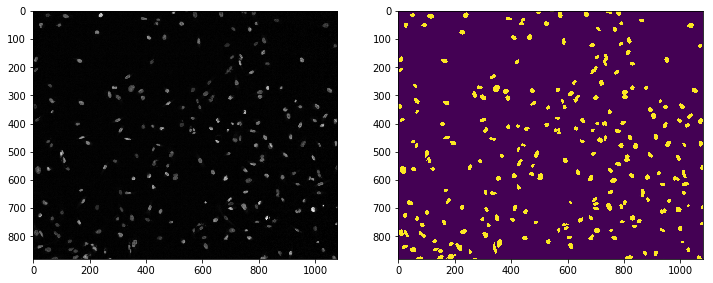

In [89]:
idx = np.random.choice(num_train_data)
img, mask = _get_image_from_path(x_train_fnames[idx], y_train_fnames[idx])

plt.figure(figsize=(12,16))
plt.subplot(1,2,1)
plt.imshow(img[:,:,0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(mask[:,:,0])

In [90]:
print(img.shape)
print(img.dtype)
print(mask.shape)
print(img.numpy().max())

(880, 1080, 1)
<dtype: 'uint8'>
(880, 1080, 1)
251


### Data augmentation

In [36]:
def flip_images(to_flip, img, mask):
    """Flip image and mask horizonally and vertically with prob = 0.5 (separately)"""
    if to_flip:
        flip_prob = tf.random_uniform([2], 0, 1) # [horizontal, vertical]
        
        # flip horizontally
        img, mask = tf.cond(tf.less(flip_prob[0], 0.5), 
                            lambda: (tf.image.flip_left_right(img), 
                                     tf.image.flip_left_right(mask)),
                            lambda: (img, mask))
        # flip vertically
        img, mask = tf.cond(tf.less(flip_prob[1], 0.5), 
                            lambda: (tf.image.flip_up_down(img), 
                                     tf.image.flip_up_down(mask)),
                            lambda: (img, mask))
    return img, mask

In [58]:
def random_crop(img, mask, size=[500, 700]):
    if size is not None:
        assert len(size) == 2, "size must have 2 elments"
        # Combine image and maks then crop
        comb = tf.concat([img, mask], axis=2)
        crop_size = comb.shape.as_list()
        crop_size[:2] = size
        comb = tf.random_crop(comb, size=crop_size)

        # Take out copped image and mask
        img_dim = img.shape[-1]
        img = comb[:,:,:img_dim]
        mask = comb[:,:,img_dim:]
    
    return img, mask

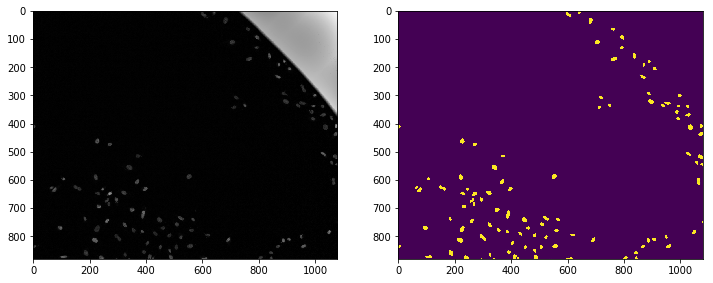

In [61]:
img2, mask2 = random_crop(img, mask, size=None)

plt.figure(figsize=(12,16))
plt.subplot(1,2,1)
plt.imshow(img2[:,:,0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(mask2[:,:,0])

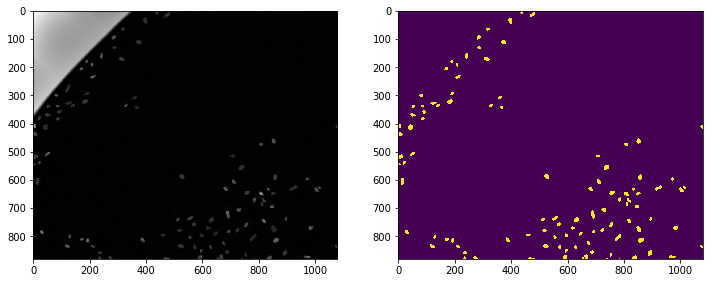

In [62]:
img3, mask3 = flip_images(True, img2, mask2)

plt.figure(figsize=(12,16))
plt.subplot(1,2,1)
plt.imshow(img3[:,:,0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(mask3[:,:,0])

### Assemble the augmenting function

In [94]:
def _augment(img, mask, resize=None, scale=1., crop_size=None, to_flip=False):
    if resize is not None:
        img = tf.image.resize(img, size=resize)
        mask = tf.image.resize(mask, size=resize)
    
    # Crop and flip
    img, mask = random_crop(img, mask, size=crop_size)
    img, mask = flip_images(to_flip, img, mask)
    
    # Scale the intensity
    img = tf.to_float(img) * scale
    mask = tf.to_float(mask) * scale
    
    return img, mask

In [99]:
def get_dataset(img_paths, mask_paths, preproc_fn=functools.partial(_augment),
                shuffle=False, batch_size=batch_size, threads=5):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    dataset = dataset.map(_get_image_from_path, num_parallel_calls=threads)    
    dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
    
    if shuffle:
        n_samples = len(img_paths)
        dataset = dataset.shuffle(n_samples)
    
    dataset = dataset.repeat().batch(batch_size)
    
    return dataset    

functools.partial(<function _augment at 0x7f296c112ae8>)


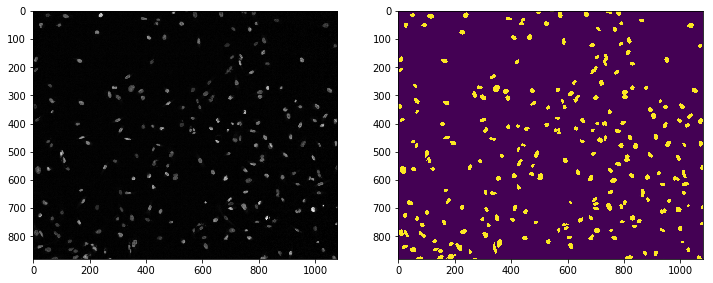

In [97]:
# img, mask = _augment(img, mask)
fn = functools.partial(_augment)
print(fn)
img, mask = fn(img, mask)

plt.figure(figsize=(12,16))
plt.subplot(1,2,1)
plt.imshow(img[:,:,0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(mask[:,:,0])

### Test the input pipeline

In [100]:
tmp_ds = get_dataset(x_train_fnames, y_train_fnames)

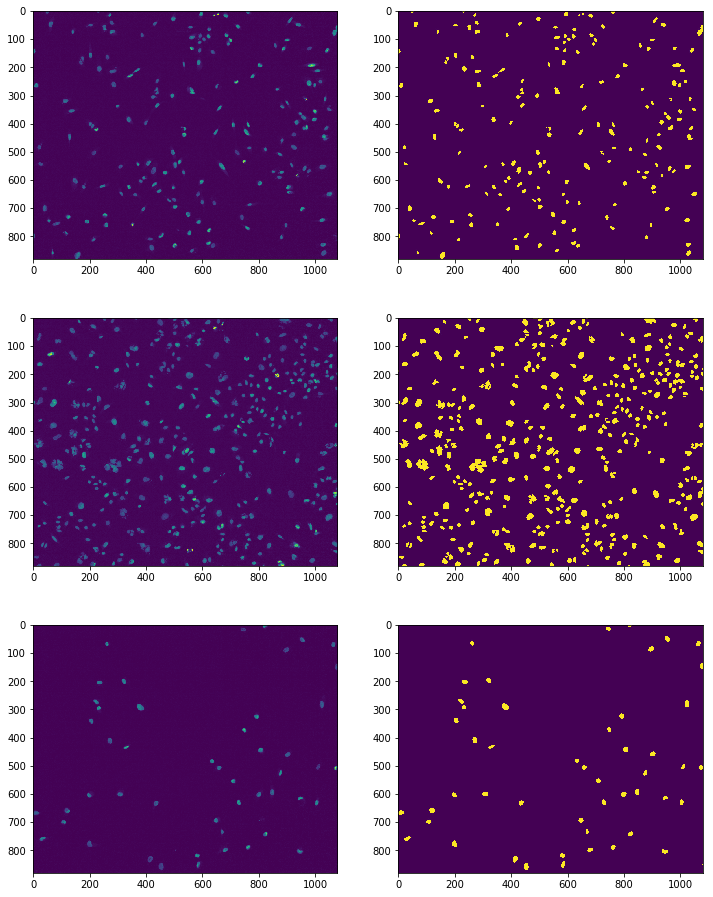

In [102]:
plt.figure(figsize=(12,16))
for i, (img, mask) in enumerate(tmp_ds.take(3)):
    plt.subplot(3,2,2*i+1)
    plt.imshow(img[0,:,:,0])
    plt.subplot(3,2,2*i+2)
    plt.imshow(mask[0,:,:,0])
plt.show()

### Configure training and validation datasets

In [147]:
# training data
train_cfg = {
    'resize': None, 
    'scale': 1.,
    'crop_size': [512, 512],
    'to_flip': True
}
tr_preproc_fn = functools.partial(_augment, **train_cfg)

# validation data
val_cfg = {
    'resize': None, 
    'scale': 1.,
}
val_preproc_fn = functools.partial(_augment, **val_cfg)

In [148]:
train_ds = get_dataset(x_train_fnames, y_train_fnames, preproc_fn=tr_preproc_fn, 
                       shuffle=True, batch_size=batch_size)
val_ds = get_dataset(x_val_fnames, y_val_fnames, preproc_fn=val_preproc_fn, 
                     shuffle=False, batch_size=batch_size)

# Build the model

In [144]:
class Conv_block(layers.Layer):
    def __init__(self, num_filters, name='conv_block'):
        super().__init__(name=name)
        self.num_filters = num_filters
        self.conv2d_1 = layers.Conv2D(num_filters, (3, 3), padding='same')
        self.bn_1 = layers.BatchNormalization()
        self.activation_1 = layers.Activation('relu')
        self.conv2d_2 = layers.Conv2D(num_filters, (3, 3), padding='same')
        self.bn_2 = layers.BatchNormalization()
        self.activation_2 = layers.Activation('relu')
        
    def call(self, inputs):
        x = self.conv2d_1(inputs)
        x = self.bn_1(x)
        x = self.activation_1(x)
        x = self.conv2d_2(x)
        x = self.bn_2(x)
        x = self.activation_2(x)
        return x


class Encoder(layers.Layer):
    def __init__(self, num_filters, name='encoder'):
        super().__init__(name=name)
        self.num_filters = num_filters
        self.conv_block = Conv_block(num_filters)
        self.mp2d = layers.MaxPool2D((2, 2), strides=(2, 2))
        
    def call(self, inputs):
        x = self.conv_block(inputs)
        x_pool = self.mp2d(x)
        return x_pool, x


class Decoder(layers.Layer):
    def __init__(self, num_filters, name='decoder'):
        super().__init__(name=name)
        self.num_filters = num_filters
        self.conv2d_tr = layers.Conv2DTranspose(num_filters, (2, 2), 
                                                strides=(2, 2), padding='same')
        self.bn = layers.BatchNormalization()
        self.activation = layers.Activation('relu')
        self.conv_block = Conv_block(num_filters)
        
    def call(self, inputs, concat_tensor):
        x = self.conv2d_tr(inputs)
        x = layers.concatenate([x, concat_tensor], axis=-1)
        x = self.bn(x)
        x = self.activation(x)
        x = self.conv_block(x)
        return x


class Unet(models.Model):
    def __init__(self, n_filters_list, name='u_net'):
        assert type(n_filters_list) is list, "n_filters_list must be a list"
        super().__init__(name=name)
        self.conv_block_center = Conv_block(n_filters_list[-1] * 2)
        self.conv_block_final = Conv_block(n_filters_list[0])
        self.con2d_1x1 = layers.Conv2D(1, (1, 1), activation='sigmoid')        
        
        self.encoders = [Encoder(n_filters) for n_filters in n_filters_list]
        self.decoders = [Decoder(n_filters) for n_filters in reversed(n_filters_list)]
        
    def call(self, inputs):
        # Encoding cascade
        x_pools = []
        xs = []
        for i, encoder in enumerate(self.encoders):
            if i == 0:
                tmp_pool, tmp = encoder(inputs)                
            else:
                tmp_pool, tmp = encoder(x_pools[i-1])
                
            x_pools.append(tmp_pool)
            xs.append(tmp)
        
        # Center convolution block
        z = self.conv_block_center(x_pools[-1])
        
        # Decoding cascade
        xs = xs[::-1] # to match the order of decoders
        for i, decoder in enumerate(self.decoders):
            z = decoder(z, xs[i])
        
        # Final 1x1 convolution
        z = self.conv_block_final(z)
        z = self.con2d_1x1(z)
        return z

### Test model

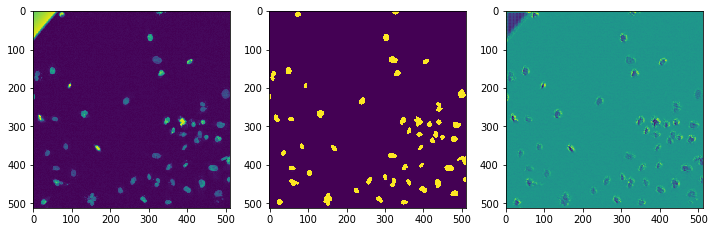

In [150]:
model = Unet([32, 64, 128, 256])

plt.figure(figsize=(12,16))
for i, (img, mask) in enumerate(train_ds.take(1)):
    y_pred = model(img)
    
    plt.subplot(1,3,1)
    plt.imshow(img[0,:,:,0])
    plt.subplot(1,3,2)
    plt.imshow(mask[0,:,:,0])
    plt.subplot(1,3,3)
    plt.imshow(y_pred[0,:,:,0])
plt.show()